#Bibliotecas



In [70]:
!pip install pymoo
!pip install pygmo

In [71]:
from scipy.spatial.distance import cdist
from math import comb, sqrt
from pymoo.core.individual import Individual
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.core.population import Population
import pygmo

import math
import numpy as np
import colorsys
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it


#MaxMin


##Teste geração de pontos e maior distância

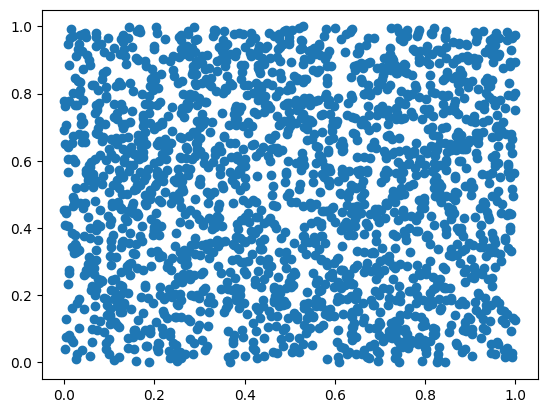

In [72]:
np.random.seed(seed=928393774)
x = np.random.random_sample((2000, 2))
if (x.shape[1] == 2):
  plt.scatter(x[:,0],x[:,1]) #Visualização de uma matriz de pontos aleatorios com seed fixa
else:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Malha')

    ax.scatter(x[:,0],x[:,1],x[:,2])
plt.show()

np.set_printoptions(suppress=True)

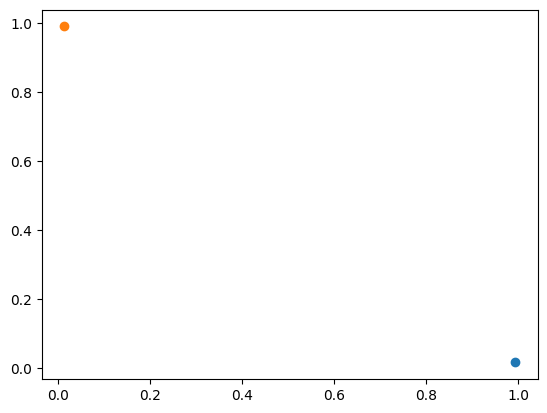

In [73]:
distances = cdist(x,x)
maxdist = np.argmax(distances) #Encontrando os pontos mais distantes entre si na nossa matriz de pontos
xi,xj =  np.unravel_index(maxdist, distances.shape) # Pegando os valores a partir do indice e plotando
if (x.shape[1] == 2):
  plt.scatter(x[xi,0],x[xi,1])
  plt.scatter(x[xj,0],x[xj,1])
elif (x.shape[1] == 3):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.set_title('Malha')
  #ax.scatter(test[:,0],test[:,1],test[:,2], color='blue')
  ax.scatter(x[xi,0],x[xi,1],x[xi,2])
  ax.scatter(x[xj,0],x[xj,1],x[xj,2])

plt.show()

In [74]:
#Conferindo valores gerados pelo cdist de distância euclidiana em 3 ou mais dimensões
TD = np.array([[0.40168178, 0.67349954, 0.5407875 ],
              [0.43695799, 0.57729513, 0.36559849],
              [0.75443572, 0.6111582,  0.6840591 ],
              [0.42871869, 0.8220766,  0.82533306]])

FD = np.array([[0.00827287, 0.60611281, 0.37338034, 0.05661359],
 [0.50266682, 0.47820265, 0.61410005, 0.39386367],
 [0.10521404, 0.46552102, 0.42443197, 0.6153319 ],
 [0.3049787,  0.35105765, 0.21129862, 0.54443886]])


print(cdist(TD,TD), '\n')
print(cdist(FD,FD))

#Comparando com a abordagem ineficiente de Fors

def testEucDist(P):
  results = []
  for ponto1 in P:
    DistanceSinglePoint = []
    for ponto2 in P:
      sum = 0
      for c in range(0,len(ponto1)):
        sum += (ponto2[c] - ponto1[c])**2
      DistanceSinglePoint.append(sqrt(sum))
    results.append(DistanceSinglePoint)

  for result in results:
    print(result)

testEucDist(TD)
testEucDist(FD)



[[0.         0.20295539 0.38580894 0.3221371 ]
 [0.20295539 0.         0.45095008 0.52090472]
 [0.38580894 0.45095008 0.         0.41296064]
 [0.3221371  0.52090472 0.41296064 0.        ]] 

[[0.         0.6576245  0.58646062 0.64601197]
 [0.6576245  0.         0.49310414 0.49006971]
 [0.58646062 0.49310414 0.         0.3216511 ]
 [0.64601197 0.49006971 0.3216511  0.        ]]
[0.0, 0.2029553860339565, 0.3858089374613803, 0.3221371027626363]
[0.2029553860339565, 0.0, 0.45095008224564054, 0.5209047215882534]
[0.3858089374613803, 0.45095008224564054, 0.0, 0.4129606359747409]
[0.3221371027626363, 0.5209047215882534, 0.4129606359747409, 0.0]
[0.0, 0.6576244992929616, 0.5864606216203149, 0.6460119675418914]
[0.6576244992929616, 0.0, 0.4931041406634146, 0.4900697130691871]
[0.5864606216203149, 0.4931041406634146, 0.0, 0.32165110051006607]
[0.6460119675418914, 0.4900697130691871, 0.32165110051006607, 0.0]


##Funcoes objetivo

In [75]:
def funcaoObj(pontos):
  pontosObj = np.empty((pontos.shape[0],2))
  for c in range(pontos.shape[0]):
    pontosObj[c] = [np.dot((pontos[c,0:2] - [1,1]),np.transpose(pontos[c,0:2] - [1,1])), np.dot((pontos[c,0:2] - [3,3]),np.transpose(pontos[c,0:2] - [3,3]))]

  return pontosObj


def funcaoObj2(pontos, gamma = 0.5):
  pontosObj = np.empty((pontos.shape[0],2))
  n = pontos.shape[1]

  for c in range(pontos.shape[0]):
    pontosObj[c] = [((np.abs(pontos[c]).sum())**gamma)*n**-gamma,((np.abs(pontos[c] - 1).sum())**gamma)*n**-gamma ]

  return pontosObj


[[ 1.5927605  -1.00512355]
 [-1.62566514 -2.70383491]
 [ 3.72812257 -1.14372271]
 [-2.01501974  0.57465875]
 [ 1.85211878  3.87025782]
 [ 2.4249643   2.50288546]
 [ 3.84756394  4.0038701 ]
 [-0.77253314  0.22372227]
 [ 1.65975384 -0.49408208]
 [-2.40683075  2.32577151]
 [-1.91010029  2.89756773]
 [-3.68638453 -4.65447846]]


Text(0.5, 1.0, 'Espaco Objetivo')

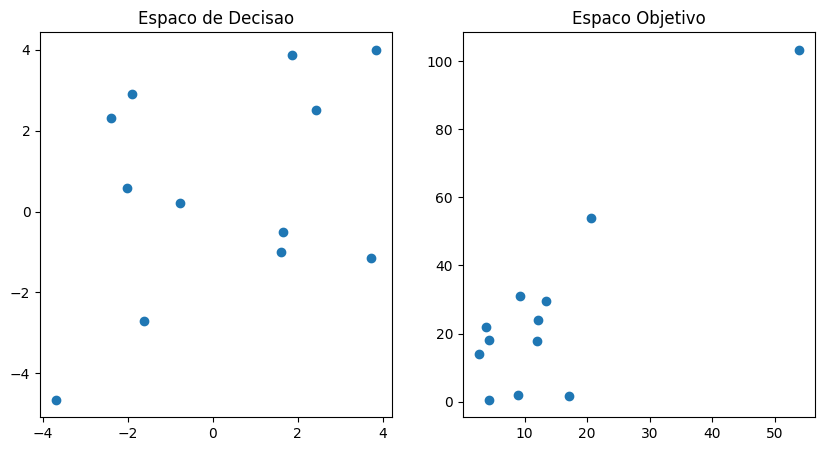

In [76]:
np.random.seed(seed=116273882)
pontosT = (np.random.random_sample((12,2)) - 0.5)*10 #Gerando valores entre -5 e 5
pontosO = funcaoObj(pontosT)
print(pontosT)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(pontosT[:,0],pontosT[:,1])
plt.title('Espaco de Decisao')
plt.subplot(1,2,2)
plt.scatter(pontosO[:,0],pontosO[:,1])
plt.title('Espaco Objetivo')

[[0.65927605 0.39948764 0.33743349]
 [0.22961651 0.87281226 0.38562773]
 [0.29849803 0.55746588 0.68521188]
 [0.88702578 0.74249643 0.75028855]
 [0.88475639 0.90038701 0.42274669]
 [0.52237223 0.66597538 0.45059179]
 [0.25931693 0.73257715 0.30898997]
 [0.78975677 0.13136155 0.03455215]
 [0.31110125 0.90073219 0.28836471]
 [0.17293854 0.85676612 0.77406003]
 [0.33813738 0.79987083 0.25693538]
 [0.28357536 0.89712403 0.42692118]]


Text(0.5, 1.0, 'Espaco Objetivo')

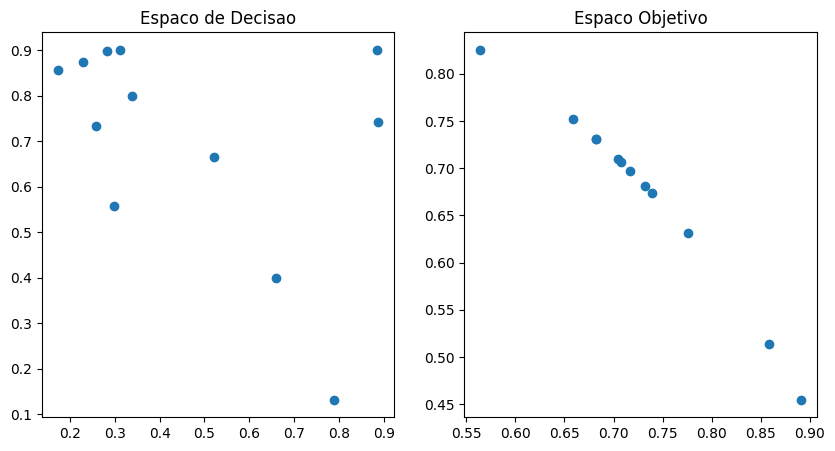

In [77]:
np.random.seed(seed=116273882)
pontosT = (np.random.random_sample((12,3))) #Gerando valores entre 0 e 1
pontosO = funcaoObj2(pontosT)
print(pontosT)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(pontosT[:,0],pontosT[:,1])
plt.title('Espaco de Decisao')
plt.subplot(1,2,2)
plt.scatter(pontosO[:,0],pontosO[:,1])
plt.title('Espaco Objetivo')

##Maxmin e testes

In [78]:
def DominaX(indice, strengthMat, strengthsSum):
  return (strengthMat[:,indice]*strengthsSum).sum()

#Definido novamente mais tarde no código por motivos de clareza

In [79]:
def maxMin(points, scalar, cdistFunc, funcaoObj = funcaoObj, dx = DominaX, profundidade = False):

  pontosInit = points

  if (cdistFunc == cdist):
    distances = cdist(points,points)
  elif (profundidade == False) :
    Mat = DWUcdistMat(points, strengthMat(points, imprimir=False, funcaoObj=funcaoObj), dx=dx)
    distances = DWUcdistMemo(points,points,Mat, pontosInit)
  else:
    Mat = DWUcdistMat(points, calculaProfundidades(points, funcaoObj = funcaoObj), dx=dx, profundidade = True)
    distances = DWUcdistMemo(points,points,Mat, pontosInit)
  maxdist = np.argmax(distances) #Pega o indice dos pontos mais distantes entre si
  xi,xj =  np.unravel_index(maxdist, distances.shape) #Pega o valor a partir dos indices
  R = np.array([points[xi,:],points[xj,:]]) #Cria um conjunto com esses dois pontos inicialmente
  points = np.delete(points,[xi,xj],axis=0) # Retira os pontos da matriz P original

  while (np.shape(R)[0] < scalar):
    if (cdistFunc == cdist):  #Calcula a menor distância entre cada ponto até um valor no conjunto R
      min = np.min(cdist(points,R), axis=1)
    else:
      min = np.min(DWUcdistMemo(points, R, Mat, pontosInit), axis=1)
    index = np.argmax(min) # Da matriz de valores minimos, pega o máximo
    pointToAdd = points[index,:] # Pega o valor correspondente do indice recuperado
    R = np.append(R,[pointToAdd],axis=0)  # Adiciona o ponto ao R
    points = np.delete(points,[index],axis=0) # Retira de P
  return R

In [80]:
def TestMaxMin(testValues, scalar, dim, cdistFunc = cdist, range = None, dx = DominaX, Profundidade = False, maxMin = maxMin):
  fig = plt.figure(figsize=(10,10*int(len(testValues)/4))) #Alterando valor da figura pra gráficos saírem quadrados
  for c,value in enumerate(testValues):
    if (range == None):
      test = np.random.random_sample((value, dim)) #Cria sample, realiza maxmin, e plota valores
    else:
      test = np.random.uniform(range[0],range[1], size=(value,dim))
    pontosT = test
    Result = maxMin(test,scalar, cdistFunc, dx=dx, profundidade = Profundidade)


    if (dim == 2):
      ax = fig.add_subplot(int(len(testValues)/2),2,c+1)
      ax.set_title(value)
      ax.scatter(test[:,0],test[:,1])
      ax.scatter(Result[:,0],Result[:,1])
    elif (dim == 3):
      ax = fig.add_subplot(int(len(testValues)/2),2,c+1,projection='3d')
      ax.set_title(value)
      #ax.scatter(test[:,0],test[:,1],test[:,2], color='blue')
      ax.scatter(Result[:,0],Result[:,1],Result[:,2],marker='D',color='red')
    else:
      count = 0
      fig = plt.figure(figsize=(3*int(comb(dim,2)),3*int(comb(dim,2))*int(len(testValues)/2)))
      for dim1 in range(0,dim):
        for dim2 in range(dim1+1,dim):
          if (dim1 != dim2):
            ax = fig.add_subplot(int(comb(dim,2))*int(len(testValues)/2),int(comb(dim,2)),count+1)
            ax.set_title(value)
            ax.set_ylabel('Dim ' + str(dim1))
            ax.set_xlabel('Dim ' + str(dim2))
            ax.scatter(test[:,dim1],test[:,dim2])
            ax.scatter(Result[:,dim1],Result[:,dim2])
            count+=1

  plt.show()



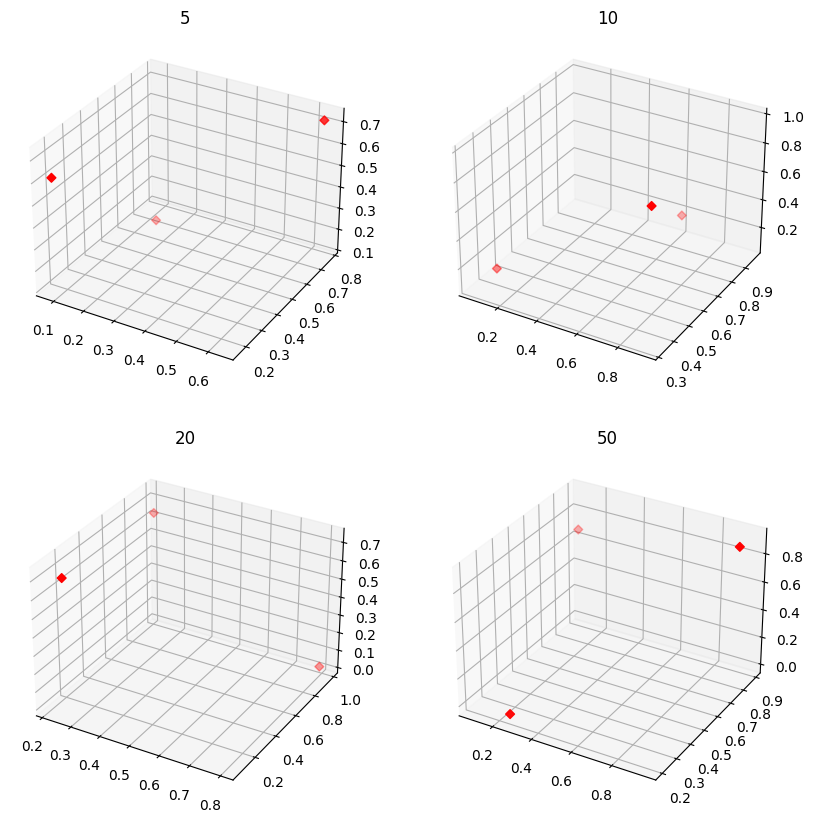

In [81]:
testValues = [5,10,20,50]
TestMaxMin(testValues,3,3)

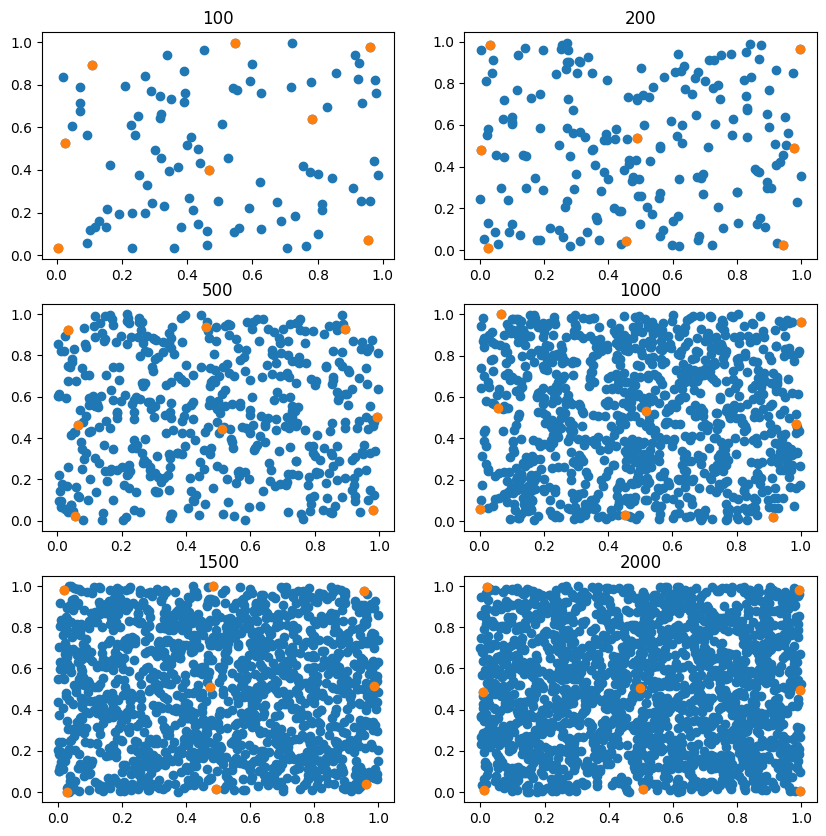

In [82]:
testValues = [100,200,500,1000,1500,2000]
TestMaxMin(testValues,8,2)

#Dominância


##Dominação

In [83]:
#Função de Dominância. p1 Domina p2 se todos os valores de p1 forem menores que seus correspondentes em p2
def Domina(p1,p2):
  return np.all(np.less_equal(p1,p2))

Test1P1 = [0.12345]
Test1P2 = [0.9]

print(Domina(Test1P1, Test1P2)) #Deve ser True

Test2P1 = [0.1,0.2,0.3,0.4,0.5]
Test2P2 = [0.2,0.3,0.4,0.5,0.6]

print(Domina(Test2P1,Test2P2)) #Deve ser True

Test3P1 = [0.1,0.2,0.3,0.4]
Test3P2 = [0.2,0.3,0.1,0.2]

print(Domina(Test3P1,Test3P2)) #Deve ser False

True
True
False


In [84]:
def strengthMat(pontos, imprimir = True, funcaoObj = funcaoObj):
  pontosO = funcaoObj(pontos)
  strengths = np.full((np.shape(pontosO)[0],np.shape(pontosO)[0]), -1 )
  #Cria matriz de Dominância baseada nos pontos no espaço Objetivo

  np.fill_diagonal(strengths, 0)


  for (p1,p2) in it.permutations(range(np.shape(pontosO)[0]),2):
    if (strengths[p1,p2] == -1):
      if Domina(pontosO[p1],pontosO[p2]):
        strengths[p1,p2] = 1
        strengths[p2,p1] = 0
        if (imprimir == True):
          print(pontosO[p1], "Domina ", pontosO[p2])
      else:
        strengths[p1,p2] = 0


  # Para cada ponto, imprime se ele domina cada outro ponto, a quantidade de pontos que ele domina, e a quantidade de pontos que ele é dominado
  if (imprimir == True):
    for forcas in range(np.shape(strengths)[0]):
      print("Dominancia de ", pontosO[forcas], ": ", strengths[forcas].astype(int), strengths[forcas].sum(), np.transpose(strengths, axes=(1,0))[forcas].sum())
  return strengths

np.random.seed(seed=928393774)
x = np.random.uniform(-5,5, size=(10,2))
strengths = strengthMat(x)


[ 2.43083423 19.1960554 ] Domina  [35.01783637 66.44240908]
[ 2.43083423 19.1960554 ] Domina  [34.66252611 73.46276887]
[ 2.43083423 19.1960554 ] Domina  [ 4.26909982 19.95055098]
[ 2.43083423 19.1960554 ] Domina  [26.28977444 59.46037208]
[ 2.43083423 19.1960554 ] Domina  [14.90098582 44.65953163]
[ 2.43083423 19.1960554 ] Domina  [15.41757999 41.18808074]
[ 2.43083423 19.1960554 ] Domina  [12.22534166 37.37120622]
[ 2.43083423 19.1960554 ] Domina  [19.60653715 52.60575623]
[ 4.26909982 19.95055098] Domina  [35.01783637 66.44240908]
[ 4.26909982 19.95055098] Domina  [34.66252611 73.46276887]
[ 4.26909982 19.95055098] Domina  [26.28977444 59.46037208]
[ 4.26909982 19.95055098] Domina  [14.90098582 44.65953163]
[ 4.26909982 19.95055098] Domina  [15.41757999 41.18808074]
[ 4.26909982 19.95055098] Domina  [12.22534166 37.37120622]
[ 4.26909982 19.95055098] Domina  [19.60653715 52.60575623]
[26.28977444 59.46037208] Domina  [35.01783637 66.44240908]
[26.28977444 59.46037208] Domina  [34.66

In [85]:
#Soma da força dos pontos que dominam o ponto de indice X
def DominaX(indice, strengthMat, strengthsSum):
  return (strengthMat[:,indice]*strengthsSum).sum()



Soma da força dos pontos que dominam o ponto X

In [86]:
'''
A solução [ 4.26909982 19.95055098] é dominada por 2 soluções:
[ 3.10592015 17.51536537],
[ 2.43083423 19.1960554 ]

[ 3.10592015 17.51536537] Domina 8 pontos,
[ 2.43083423 19.1960554 ] Domina 8 pontos

A resposta deve ser 16

esse é nosso d(x)
'''
print(DominaX(3, strengths, [i.sum() for i in strengths]))

16


In [87]:
def DWUcdistMat(pontos, strengths, dx=DominaX, profundidade = False):
  MatX = np.zeros(np.shape(pontos)[0]) #Cria array vazio
  strengthsSum = [i.sum() for i in strengths] #Cria uma soma das forças para usar em DominaX

  if (profundidade == False):
    MatX = np.array([dx(c, strengths, strengthsSum) for c in range(np.shape(pontos)[0])]) #Cria uma matriz de d(x)
  else:
    MatX = np.array([dx(c, strengths, strengthsSum) for c in (pontos)]) #Cria uma matriz de d(x)

  dxMat =  np.abs(np.subtract.outer(MatX,MatX)) + 1 #Calcula a parte de baixo da fórmula de wd(x) de cada ponto
  return (cdist(pontos,pontos))/dxMat #retorna uma matriz dos wd(x) de cada par de pontos


np.random.seed(seed=928393774)
y = np.random.random_sample((5, 2))
strengthsDWU = strengthMat(y, imprimir=False)
Mat = DWUcdistMat(y, strengthsDWU)

In [88]:
y

array([[0.00827287, 0.60611281],
       [0.37338034, 0.05661359],
       [0.50266682, 0.47820265],
       [0.61410005, 0.39386367],
       [0.10521404, 0.46552102]])

In [89]:
strengthsDWU

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1],
       [1, 1, 1, 0, 1],
       [0, 1, 0, 0, 0]])

Segundo a matriz de dominância, o ponto [0.00827287, 0.60611281] é dominado por [0.50266682, 0.47820265] e [0.61410005, 0.39386367]. A soma de suas dominâncias é 7

Também segundo a matriz, o ponto [0.37338034, 0.05661359] é dominado por todos os outros. A soma de suas dominâncias é 9

Para calcular o wd entre esses dois pontos, x e x', basta calcular

sqrt((0.00827287 - 0.37338034)² + (0.60611281 - 0.05661359)²) / |7 - 9| + 1

que equivale a 0.65973696078 / 3
que equivale a 0.21991232026

Observando a matriz na posição [0,1], é possível ver que o valor está correto



In [90]:
print(Mat)

[[0.         0.21991232 0.12766812 0.08024146 0.17077366]
 [0.21991232 0.         0.07349458 0.04143472 0.16299913]
 [0.12766812 0.07349458 0.         0.02795026 0.09941376]
 [0.08024146 0.04143472 0.02795026 0.         0.0642383 ]
 [0.17077366 0.16299913 0.09941376 0.0642383  0.        ]]


In [91]:
def DWUcdistMemo(p1, p2, Mat, FullP):

    #Nessa função é feito apenas um "recorte" da matriz completa, que inclui apenas os pontos p1 como linhas e os pontos p2 como colunas
    #Isso é feito para não haver a necessidade de recalcular a matriz toda vez que o algoritmo é chamado para dois conjuntos de pontos diferentes

    #Convertendo os arrays numpy em listas pra achar o indíce mais rapidamente
    FullPList = FullP.tolist()
    p1list = p1.tolist()
    p2list = p2.tolist()

    #List comprehension acelera substancialmente a eficiência do código
    p1_indices = np.array([FullPList.index(x) for x in p1list])
    p2_indices = np.array([FullPList.index(x) for x in p2list])
    return Mat[p1_indices[:, None], p2_indices]

In [92]:
Mat = DWUcdistMat(y, strengthMat(y, imprimir=False))
print(DWUcdistMemo(y[1:3], y[2:4], Mat, y))

[[0.07349458 0.04143472]
 [0.         0.02795026]]


para o maxmin, o DWU é calculado e a matriz DWUcdistMat é utilizada como matriz de distâncias. o procedimento é então o mesmo

In [93]:
y

array([[0.00827287, 0.60611281],
       [0.37338034, 0.05661359],
       [0.50266682, 0.47820265],
       [0.61410005, 0.39386367],
       [0.10521404, 0.46552102]])

In [94]:
Mat

array([[0.        , 0.21991232, 0.12766812, 0.08024146, 0.17077366],
       [0.21991232, 0.        , 0.07349458, 0.04143472, 0.16299913],
       [0.12766812, 0.07349458, 0.        , 0.02795026, 0.09941376],
       [0.08024146, 0.04143472, 0.02795026, 0.        , 0.0642383 ],
       [0.17077366, 0.16299913, 0.09941376, 0.0642383 , 0.        ]])

Primeiro, é criado um conjunto com os pontos com a maior distância entre si. Observando a matriz de distâncias, esse valor corresponde aos pontos 0 e 1.

Dos pontos restantes, calculamos a distância entre eles e os pontos do conjunto inicial e pegamos a menor para cada uma.

para o ponto [0.50266682, 0.47820265] temos distância de 0.12766812 para o ponto 0 e 0.07349458 para o ponto 1. o menor deles é o segundo

para o ponto [0.61410005, 0.39386367] temos distância de 0.08024146 para o ponto 0 e 0.04143472 para o ponto 1. o menor deles é o segundo

para o ponto [0.10521404, 0.46552102] temos distância de 0.17077366 para o ponto 0 e 0.16299913 para o ponto 1. o menor deles é o segundo

dos valores 0.07349458, 0.04143472 e 0.16299913, o maior deles é o último. Portanto, o ponto [0.10521404, 0.46552102] é adicionado ao conjunto R


Agora, temos os pontos 0,1 e 4 no conjunto R. Para  calcular o proxímo ponto, repetimos a operação.

Para o ponto [0.50266682, 0.47820265], temos distâncias de 0.12766812, 0.07349458 e 0.09941376

Para o ponto [0.61410005, 0.39386367], temos distâncias de 0.08024146, 0.04143472 e 0.0642383

Entre 0.07349458 e 0.04143472 o maior é o primeiro, então o próximo ponto adicionado é [0.50266682, 0.47820265]



In [95]:
res = maxMin(y, 4, DWUcdistMemo)
print(res)

[[0.00827287 0.60611281]
 [0.37338034 0.05661359]
 [0.10521404 0.46552102]
 [0.50266682 0.47820265]]


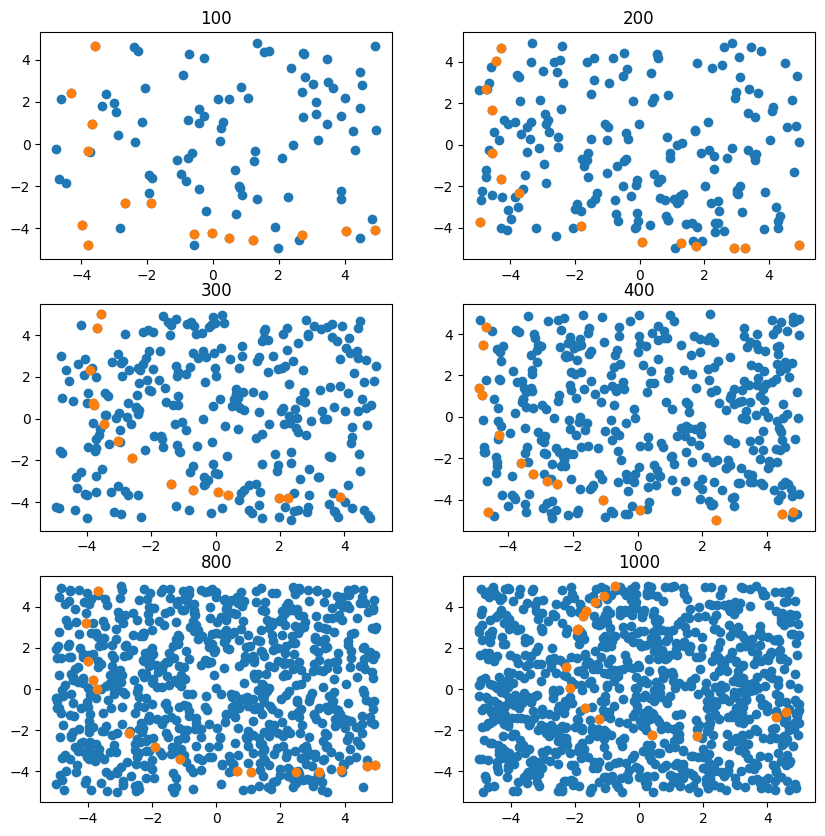

In [96]:
testValues = [100,200,300,400, 800, 1000]
TestMaxMin(testValues,15,2,cdistFunc=DWUcdistMemo, range=(-5,5))

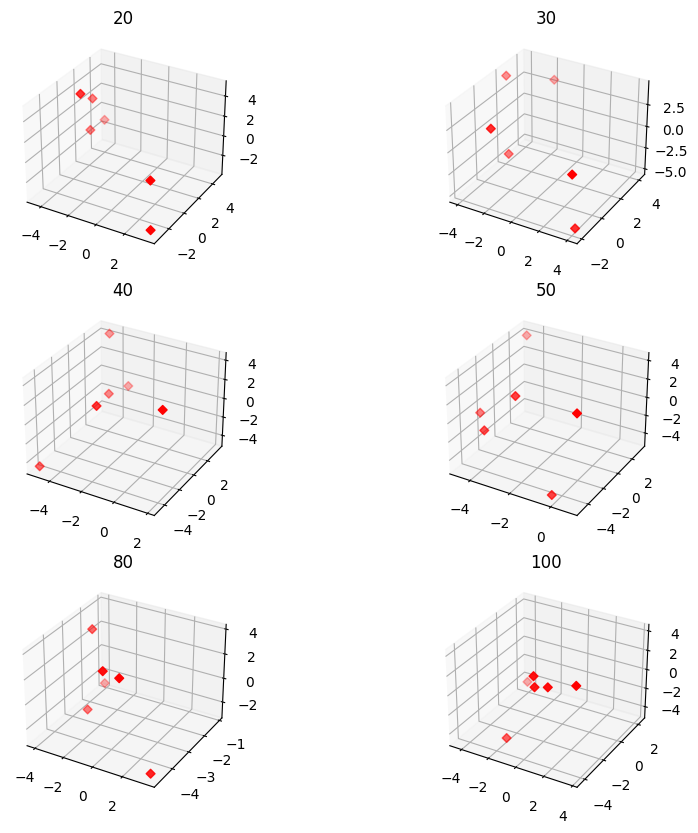

In [97]:
testValues = [20,30,40,50, 80, 100]
TestMaxMin(testValues,6,3,cdistFunc=DWUcdistMemo, range=(-5,5))

In [98]:

# fonte dessa função de encontrar pontos não dominados: https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

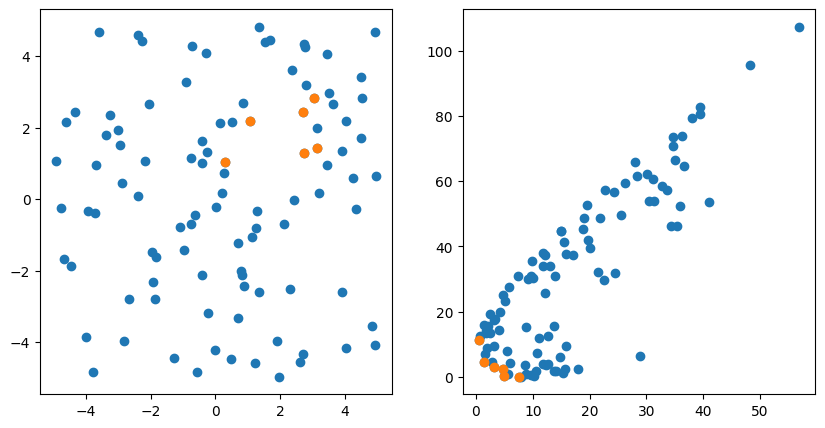

In [99]:
np.random.seed(seed=928393774)
z = np.random.uniform(-5,5, size=(100,2))
zObj = funcaoObj(z)

nomDom = zObj[is_pareto_efficient(zObj, return_mask = True)]
nomDomDecisao = z[is_pareto_efficient(zObj, return_mask = True)]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(z[:,0], z[:,1])
plt.scatter(nomDomDecisao[:, 0], nomDomDecisao[:, 1])

plt.subplot(1,2,2)
plt.scatter(zObj[:,0], zObj[:,1])
plt.scatter(nomDom[:, 0], nomDom[:, 1])


#Genético

## Funções

In [100]:
def binTor(pop, FitArray, k):
  parents = []

  for _ in range(k):
          # Randomly choose two individuals
          tournament_indices = np.random.choice(len(pop), size=2, replace=False)
          candidate1, candidate2 = pop[tournament_indices[0]], pop[tournament_indices[1]]

          # Choose the one with the better fitness

          if FitArray[tournament_indices[0]] > FitArray[tournament_indices[1]]:
              parents.append(candidate1)
          else:
              parents.append(candidate2)

  parents = np.array(parents)
  ##print(parents)
  return parents


In [101]:
def crossoverSBX(pais, r,  n = 2):
  parents = []
  for c in range(int(len(pais)/2)):
    #print(pais[c], pais[c + int(len(pais)/2)])
    a, b = Individual(X=np.array(pais[c])), Individual(X=np.array(pais[c + int(len(pais)/2)]))
    parents.append([a,b])

  problem = Problem(n_var=n, xl=r[0], xu=r[1])
  off = SBX(prob=1.0, prob_var=0.8, eta=1).do(problem, parents)

  popArr = [indi.X for indi in off]
  filhos = np.array(popArr)
  return filhos


#paisInd = [[Individual(X=np.array(pai[0])), Individual(X=np.array(pai[1]))] for pai in pais]

In [102]:
def mutatePol(filhos, r, n=2):
  population = Population.new(X=filhos)
  mutation = PolynomialMutation(prob=0.9, eta=35)

  problem = Problem(n_var=n, xl=r[0], xu=r[1])
  off = mutation(problem, population)

  popNPArrMut = [indi.X for indi in off]
  filhosMut = np.array(popNPArrMut)
  return filhosMut

## Iterador Genetico

In [103]:
def Genetico(k, max_it, progress = 25, funcaoObj = funcaoObj, r =(-5,5), n=2, dx=DominaX, profundidade = False, maxMin = maxMin):
  PopInit = np.random.uniform(r[0],r[1], size=(k,n))
  Pop = PopInit

  for t in range(max_it):
    StrengthPop = strengthMat(Pop, imprimir=False, funcaoObj = funcaoObj)
    FitArray = [x.sum() for x in StrengthPop]
    pais = binTor(Pop, FitArray, k)
    filhos = mutatePol(crossoverSBX(pais, r, n=n), r, n=n)
    paisefilhos = np.concatenate((pais, filhos), axis=0)
    #print(paisefilhos)
    Pop = maxMin(paisefilhos, k, DWUcdistMemo, funcaoObj = funcaoObj, dx=dx, profundidade = profundidade)

    if (progress != None):
      if (t%progress == 0):
        print(f'iteracao {t}/{max_it}')

  PopObj = funcaoObj(Pop)

  PopFinalnomDom = Pop[is_pareto_efficient(PopObj)]

  return PopInit, Pop, PopFinalnomDom


In [160]:
np.random.seed(seed=928393774)
PopInit, PopFinal, PopFinalnomDom = Genetico(30,500, funcaoObj = funcaoObj)

iteracao 0/500
iteracao 25/500
iteracao 50/500
iteracao 75/500
iteracao 100/500
iteracao 125/500
iteracao 150/500
iteracao 175/500
iteracao 200/500
iteracao 225/500
iteracao 250/500
iteracao 275/500
iteracao 300/500
iteracao 325/500
iteracao 350/500
iteracao 375/500
iteracao 400/500
iteracao 425/500
iteracao 450/500
iteracao 475/500


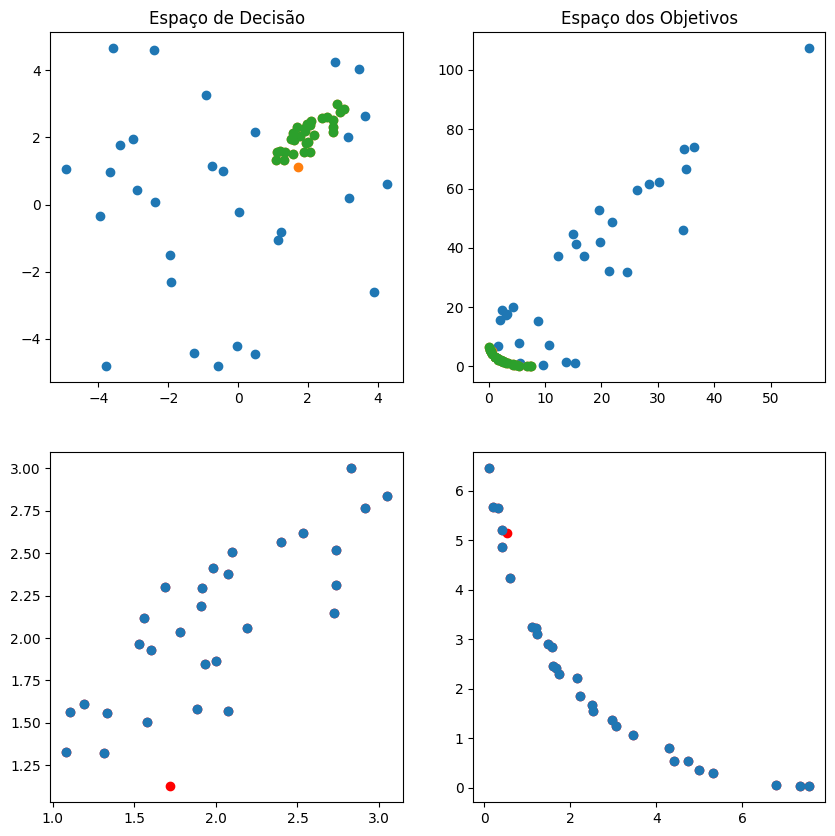

In [162]:
def GraficaGenetico(PopInit, PopFinal, PopFinalnomDom, funcaoObj):
  plt.figure(figsize=(10, 10))
  plt.subplot(2,2,1)
  plt.title('Espaço de Decisão')
  plt.scatter(PopInit[:,0], PopInit[:,1])
  plt.scatter(PopFinal[:, 0], PopFinal[:, 1])
  plt.scatter(PopFinalnomDom[:, 0], PopFinalnomDom[:, 1])

  plt.subplot(2,2,2)
  plt.title('Espaço dos Objetivos')
  plt.scatter(funcaoObj(PopInit)[:,0], funcaoObj(PopInit)[:,1])
  plt.scatter(funcaoObj(PopFinal)[:, 0], funcaoObj(PopFinal)[:, 1])
  plt.scatter(funcaoObj(PopFinalnomDom)[:, 0], funcaoObj(PopFinalnomDom)[:, 1])

  plt.subplot(2,2,3)
  plt.scatter(PopFinal[:, 0], PopFinal[:, 1], color='red')
  plt.scatter(PopFinalnomDom[:, 0], PopFinalnomDom[:, 1])
  plt.subplot(2,2,4)
  plt.scatter(funcaoObj(PopFinal)[:, 0], funcaoObj(PopFinal)[:, 1], color='red')
  plt.scatter(funcaoObj(PopFinalnomDom)[:, 0], funcaoObj(PopFinalnomDom)[:, 1])

GraficaGenetico(PopInit, PopFinal, PopFinalnomDom, funcaoObj)


iteracao 0/500
iteracao 25/500
iteracao 50/500
iteracao 75/500
iteracao 100/500
iteracao 125/500
iteracao 150/500
iteracao 175/500
iteracao 200/500
iteracao 225/500
iteracao 250/500
iteracao 275/500
iteracao 300/500
iteracao 325/500
iteracao 350/500
iteracao 375/500
iteracao 400/500
iteracao 425/500
iteracao 450/500
iteracao 475/500


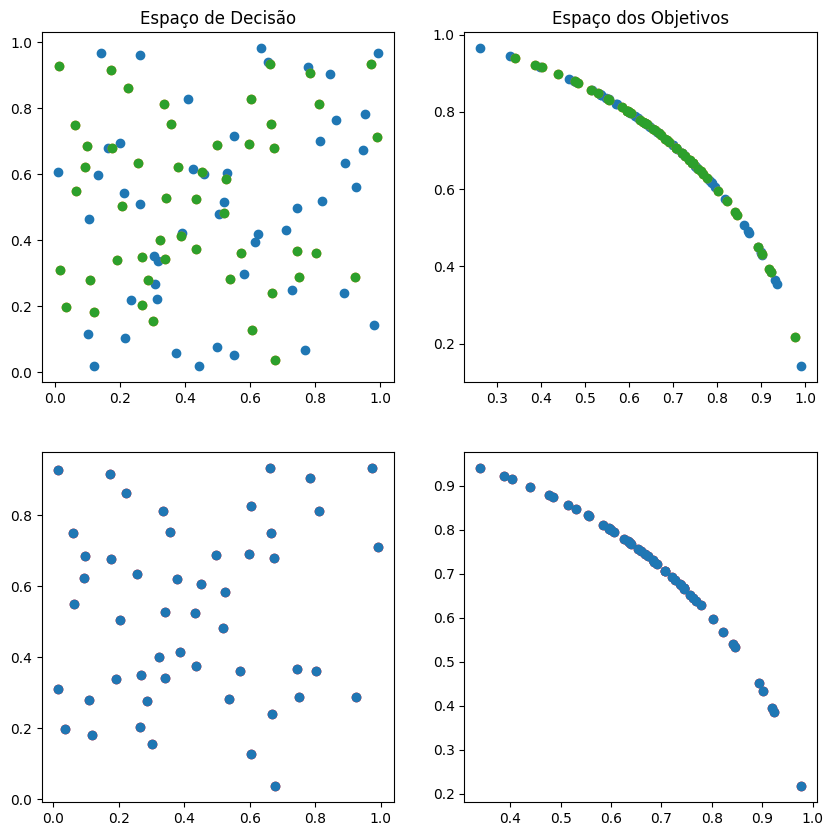

In [174]:

np.random.seed(seed=928393774)
PopInit, PopFinal, PopFinalnomDom = Genetico(50,500,r =(0,1), funcaoObj = funcaoObj2)
GraficaGenetico(PopInit, PopFinal, PopFinalnomDom, funcaoObj2)

## HiverVolume e Uniformidade

In [106]:

def calculaHV(pontos, ref, func):
  pontos = np.clip(func(pontos), 0, ref[0])
  hv_calculator = pygmo.hypervolume(pontos)
  return hv_calculator.compute(ref)

def calculaUni(pontos):
  matrix = cdist(pontos, pontos)
  np.fill_diagonal(matrix, np.inf)
  return np.min(matrix)

def calculaHV_Uni(pontos, ref, func):
  hv = calculaHV(pontos, ref, func)
  uni = calculaUni(pontos)
  return hv, uni

In [107]:

ref1 = [8,8]
ref2 = [1,1]

PopInit, PopFinal, PopFinalnomDom = Genetico(30, 500, progress=500)
hv1, uni1 = calculaHV_Uni(PopFinalnomDom, ref1, funcaoObj)

PopInit, PopFinal, PopFinalnomDom = Genetico(40, 500, progress=500)
hv2, uni2 = calculaHV_Uni(PopFinalnomDom, ref1, funcaoObj)

PopInit, PopFinal, PopFinalnomDom = Genetico(50, 500, progress=500)
hv3, uni3 = calculaHV_Uni(PopFinalnomDom, ref1, funcaoObj)


print(hv1, uni1)
print(hv2, uni2)
print(hv3, uni3)

iteracao 0/500
iteracao 0/500
iteracao 0/500
51.006650499044774 0.035034834773795584
51.60020519149747 0.02800519790173974
52.16724650841902 0.018256410078750528


In [108]:

ref1 = [8,8]
ref2 = [1,1]

PopInit, PopFinal, PopFinalnomDom = Genetico(30, 500, progress=500, funcaoObj=funcaoObj2)
hv1, uni1 = calculaHV_Uni(PopFinalnomDom, ref2, funcaoObj2)

PopInit, PopFinal, PopFinalnomDom = Genetico(40, 500, progress=500, funcaoObj=funcaoObj2)
hv2, uni2 = calculaHV_Uni(PopFinalnomDom, ref2, funcaoObj2)


PopInit, PopFinal, PopFinalnomDom = Genetico(50, 500, progress=500, funcaoObj=funcaoObj2)
hv3, uni3 = calculaHV_Uni(PopFinalnomDom, ref2, funcaoObj2)


print(hv1, uni1)
print(hv2, uni2)
print(hv3, uni3)

iteracao 0/500
iteracao 0/500
iteracao 0/500
0.1832396720739727 0.022003886434090618
0.18834395990354896 0.04111042341571908
0.19761681313906848 0.045325891693722566


# Explorando novas funções para dominância

##Dominância básica

In [109]:
#Soma de quantos pontos X domina

np.random.seed(seed=928393774)
x = np.random.uniform(-5,5, size=(10,2))
strengths = strengthMat(x)

[ 2.43083423 19.1960554 ] Domina  [35.01783637 66.44240908]
[ 2.43083423 19.1960554 ] Domina  [34.66252611 73.46276887]
[ 2.43083423 19.1960554 ] Domina  [ 4.26909982 19.95055098]
[ 2.43083423 19.1960554 ] Domina  [26.28977444 59.46037208]
[ 2.43083423 19.1960554 ] Domina  [14.90098582 44.65953163]
[ 2.43083423 19.1960554 ] Domina  [15.41757999 41.18808074]
[ 2.43083423 19.1960554 ] Domina  [12.22534166 37.37120622]
[ 2.43083423 19.1960554 ] Domina  [19.60653715 52.60575623]
[ 4.26909982 19.95055098] Domina  [35.01783637 66.44240908]
[ 4.26909982 19.95055098] Domina  [34.66252611 73.46276887]
[ 4.26909982 19.95055098] Domina  [26.28977444 59.46037208]
[ 4.26909982 19.95055098] Domina  [14.90098582 44.65953163]
[ 4.26909982 19.95055098] Domina  [15.41757999 41.18808074]
[ 4.26909982 19.95055098] Domina  [12.22534166 37.37120622]
[ 4.26909982 19.95055098] Domina  [19.60653715 52.60575623]
[26.28977444 59.46037208] Domina  [35.01783637 66.44240908]
[26.28977444 59.46037208] Domina  [34.66

In [110]:
def DominaXSum(indice, strengthMat, strengthsSum):
  return (strengthMat[indice].sum())



A partir da matriz de forças, podemos contar quantos elementos cada valor domina. Dado isso, o quarto elemento, na posição 3, domina 7

In [111]:
print(DominaXSum(3, strengths, [i.sum() for i in strengths]))

7


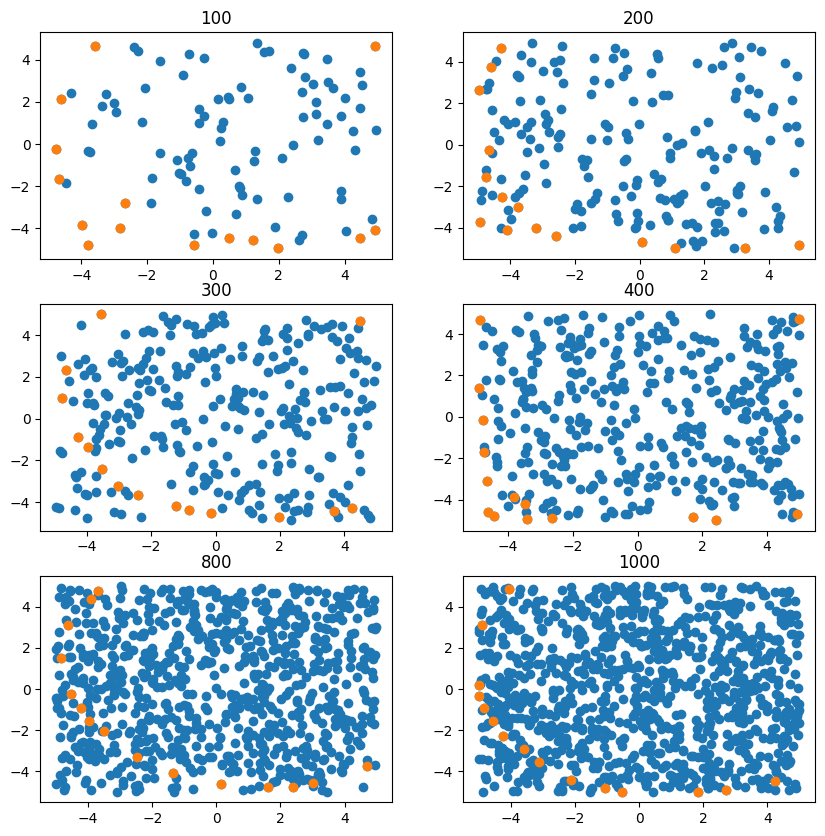

In [112]:
testValues = [100,200,300,400, 800, 1000]
TestMaxMin(testValues,15,2,cdistFunc=DWUcdistMemo, range=(-5,5), dx=DominaXSum)

In [167]:
np.random.seed(seed=928393774)
PopInit, PopFinal, PopFinalnomDom = Genetico(30,500, funcaoObj = funcaoObj, dx=DominaXSum)


iteracao 0/500
iteracao 25/500
iteracao 50/500
iteracao 75/500
iteracao 100/500
iteracao 125/500
iteracao 150/500
iteracao 175/500
iteracao 200/500
iteracao 225/500
iteracao 250/500
iteracao 275/500
iteracao 300/500
iteracao 325/500
iteracao 350/500
iteracao 375/500
iteracao 400/500
iteracao 425/500
iteracao 450/500
iteracao 475/500


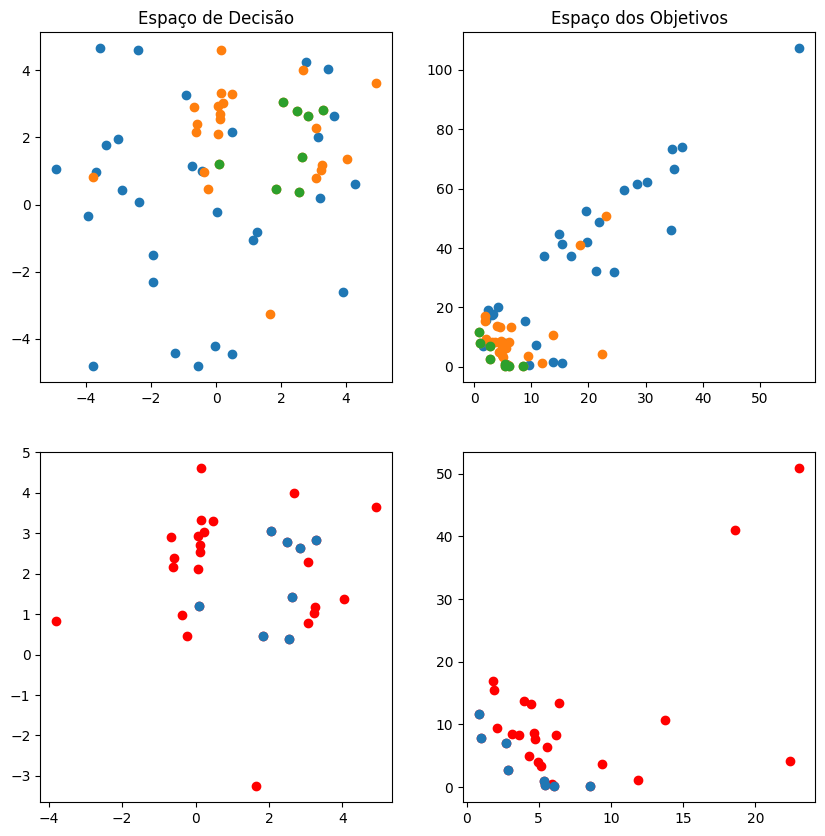

In [168]:
GraficaGenetico(PopInit, PopFinal, PopFinalnomDom, funcaoObj)

In [115]:
hv, uni = calculaHV_Uni(PopFinalnomDom, ref1, funcaoObj)
print(hv, uni)

34.2617781236521 0.38151806503882235


In [169]:
np.random.seed(seed=928393774)
PopInit, PopFinal, PopFinalnomDom = Genetico(50,500,r =(0,1), funcaoObj = funcaoObj2, dx=DominaXSum)


iteracao 0/500
iteracao 25/500
iteracao 50/500
iteracao 75/500
iteracao 100/500
iteracao 125/500
iteracao 150/500
iteracao 175/500
iteracao 200/500
iteracao 225/500
iteracao 250/500
iteracao 275/500
iteracao 300/500
iteracao 325/500
iteracao 350/500
iteracao 375/500
iteracao 400/500
iteracao 425/500
iteracao 450/500
iteracao 475/500


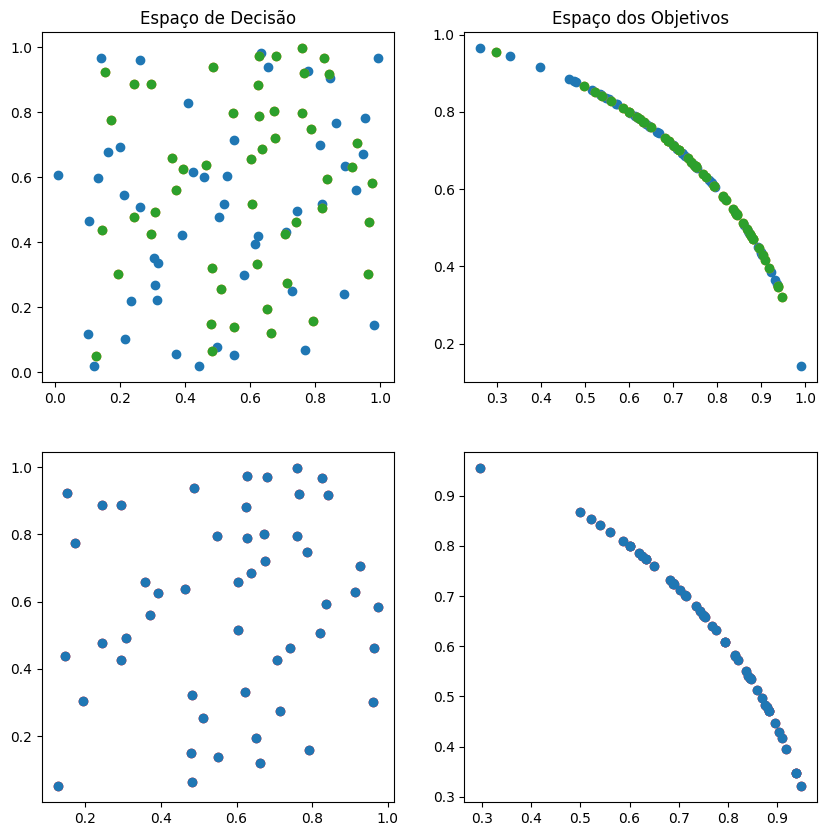

In [170]:
GraficaGenetico(PopInit, PopFinal, PopFinalnomDom, funcaoObj2)

In [118]:
hv, uni = calculaHV_Uni(PopFinalnomDom, ref2, funcaoObj2)
print(hv, uni)

0.1926970038375829 0.04442230391648721


In [119]:
np.random.seed(seed=928393774)
PopInit, PopFinal, PopFinalnomDom = Genetico(50,500,r =(0,1), n=3, funcaoObj = funcaoObj2, dx=DominaXSum)
hv, uni = calculaHV_Uni(PopFinalnomDom, ref2, funcaoObj2)
print(hv, uni)

iteracao 0/500
iteracao 25/500
iteracao 50/500
iteracao 75/500
iteracao 100/500
iteracao 125/500
iteracao 150/500
iteracao 175/500
iteracao 200/500
iteracao 225/500
iteracao 250/500
iteracao 275/500
iteracao 300/500
iteracao 325/500
iteracao 350/500
iteracao 375/500
iteracao 400/500
iteracao 425/500
iteracao 450/500
iteracao 475/500
0.1887106656392331 0.14540489240931612


In [120]:
np.random.seed(seed=928393774)
PopInit, PopFinal, PopFinalnomDom = Genetico(50,500,r =(0,1), n=10, funcaoObj = funcaoObj2, dx=DominaXSum)
hv, uni = calculaHV_Uni(PopFinalnomDom, ref2, funcaoObj2)
print(hv, uni)

iteracao 0/500
iteracao 25/500
iteracao 50/500
iteracao 75/500
iteracao 100/500
iteracao 125/500
iteracao 150/500
iteracao 175/500
iteracao 200/500
iteracao 225/500
iteracao 250/500
iteracao 275/500
iteracao 300/500
iteracao 325/500
iteracao 350/500
iteracao 375/500
iteracao 400/500
iteracao 425/500
iteracao 450/500
iteracao 475/500
0.14074191038828546 0.5698414831488009


## Profundidade

Para profundidade, usamos a função de pegar a fronteira pareto e repetimos sua operação diversas vezes, atribuindo um valor de profundidade para cada elemento.

In [121]:
np.random.seed(seed=928393774)
x = np.random.uniform(-5,5, size=(50,2))
strengths = strengthMat(x, imprimir=False)

In [122]:
def calculaProfundidades(x, funcaoObj = funcaoObj):
  profList = []
  iterador = 0
  while (len(x) > 0):
    iterador += 1
    indicesFronteira =  is_pareto_efficient(funcaoObj(x), return_mask = False)
    fronteira = x[indicesFronteira].tolist()
    x = np.delete(x, indicesFronteira, axis=0)
    profList.extend([element + [iterador] for element in fronteira])
  return np.array(profList)

In [123]:
profList = calculaProfundidades(x)
profList

array([[ 3.14756995,  2.00089657,  1.        ],
       [ 0.49815631,  2.15605726,  1.        ],
       [ 3.63961515,  2.65037675,  1.        ],
       [ 0.29184705,  1.04519545,  1.        ],
       [ 3.45478191,  4.04569271,  2.        ],
       [-0.42669156,  1.00163777,  2.        ],
       [ 2.76854147,  4.26213568,  2.        ],
       [ 3.19281237,  0.18220731,  2.        ],
       [ 2.43807217, -0.0280347 ,  2.        ],
       [ 3.90266148,  1.33795579,  2.        ],
       [ 0.20550551,  0.15996103,  2.        ],
       [ 0.02666823, -0.21797352,  3.        ],
       [-0.75568033,  1.15331903,  3.        ],
       [ 4.26130528,  0.59814243,  3.        ],
       [ 2.1042063 , -0.68594285,  3.        ],
       [ 1.53909714,  4.39274263,  3.        ],
       [ 4.48040335,  1.72232246,  3.        ],
       [ 4.5163971 ,  2.82376335,  3.        ],
       [ 1.24475552, -0.81000409,  4.        ],
       [-0.91851927,  3.27125554,  4.        ],
       [ 1.33767433,  4.81972394,  4.   

In [124]:

dims = len(x[0])
colunas =  [f'Coluna{i}' for i in range(1, dims + 1)]
colunas.append('Profundidade')

dfProf = pd.DataFrame(profList, columns=colunas)

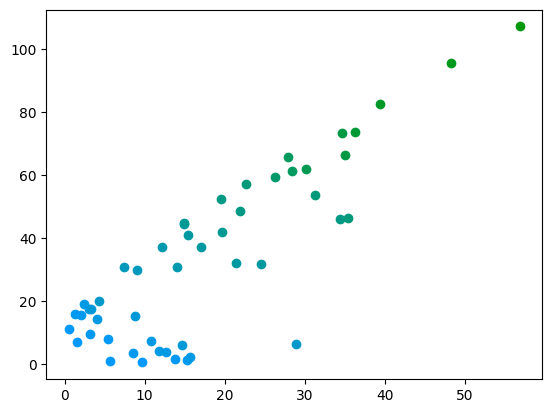

In [125]:


profMax = int(dfProf['Profundidade'].iloc[-1])
colorwheel = [] #Paleta de cores para o plot
for c in range(profMax):
  colorwheel.append((0, 0.6, 1 - c/profMax))


for c in range(1, profMax+1):
  proxProf = dfProf[dfProf['Profundidade'] == c]
  oquePlotar = funcaoObj(np.array(proxProf.drop(['Profundidade'], axis=1)))
  plt.scatter(oquePlotar[:,0], oquePlotar[:, 1], color = colorwheel[c-1])



Como esperado, o elemento [-4.91727131  1.06112813] está na profundidade 15

In [126]:

def DominaXProf(elem, profList, s = _):

  profsC = profList[:, :-1].tolist()
  profundidade = profsC.index(elem.tolist())
  return profList[profundidade, -1]


profs = calculaProfundidades(x)
elemento = x[0]
print(elemento)
print(DominaXProf(elemento, profs))




[-4.91727131  1.06112813]
15.0


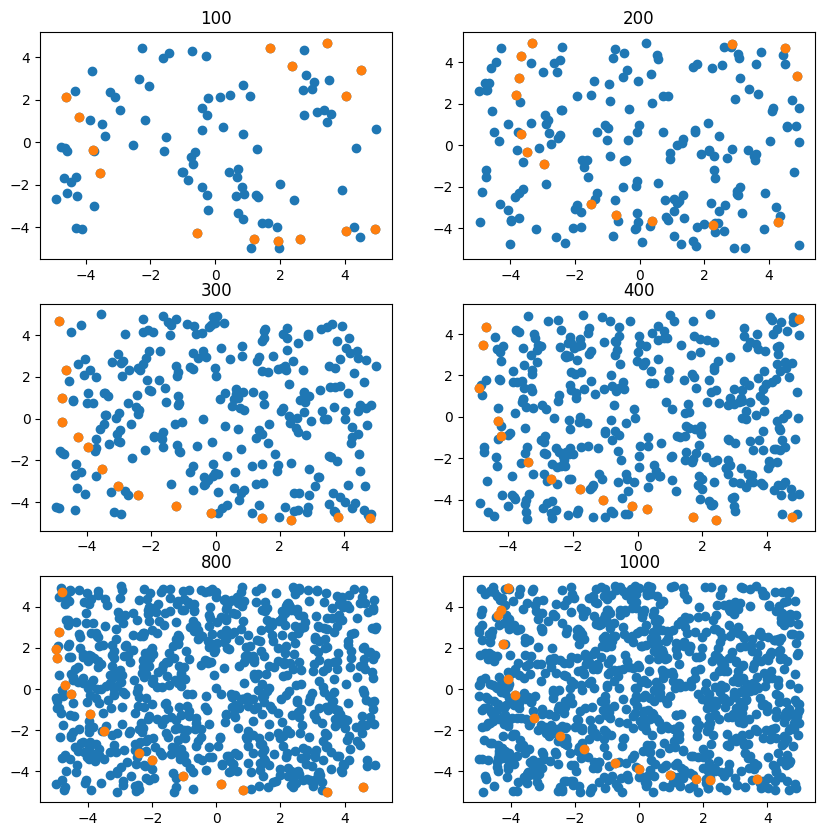

In [127]:
TestMaxMin(testValues,15,2,cdistFunc=DWUcdistMemo, range=(-5,5), dx=DominaXProf, Profundidade = True)

In [165]:
PopInit, PopFinal, PopFinalnomDom = Genetico(50,500, funcaoObj = funcaoObj, dx=DominaXProf, profundidade = True)

iteracao 0/500
iteracao 25/500
iteracao 50/500
iteracao 75/500
iteracao 100/500
iteracao 125/500
iteracao 150/500
iteracao 175/500
iteracao 200/500
iteracao 225/500
iteracao 250/500
iteracao 275/500
iteracao 300/500
iteracao 325/500
iteracao 350/500
iteracao 375/500
iteracao 400/500
iteracao 425/500
iteracao 450/500
iteracao 475/500


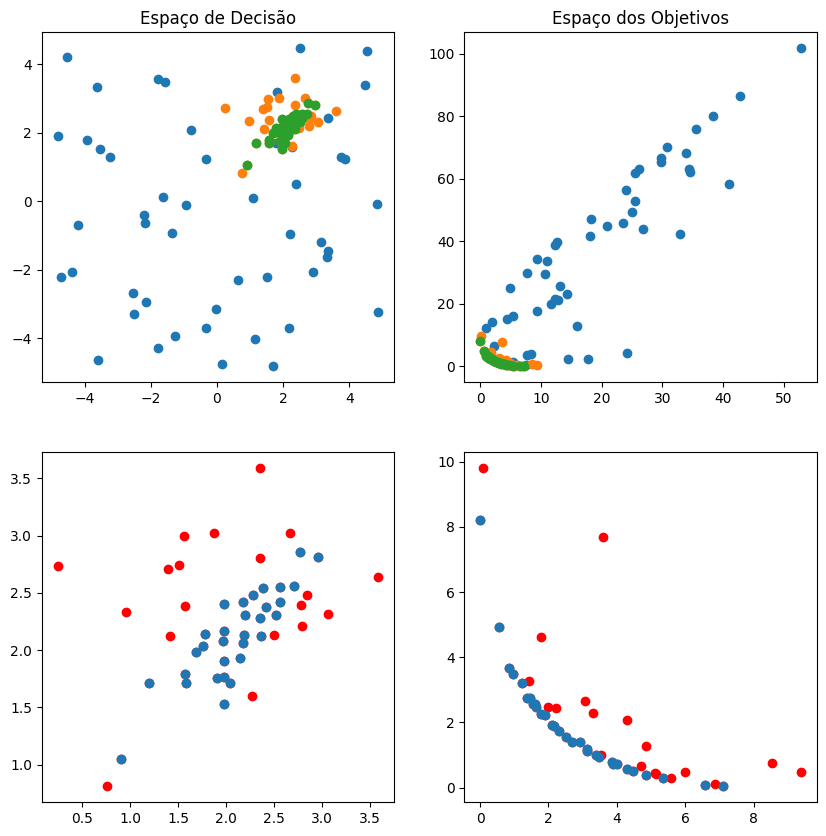

In [166]:
GraficaGenetico(PopInit, PopFinal, PopFinalnomDom, funcaoObj)

In [171]:
np.random.seed(seed=928393774)
PopInit, PopFinal, PopFinalnomDom = Genetico(50,500,r =(0,1), funcaoObj = funcaoObj2, dx=DominaXProf, profundidade = True)

iteracao 0/500
iteracao 25/500
iteracao 50/500
iteracao 75/500
iteracao 100/500
iteracao 125/500
iteracao 150/500
iteracao 175/500
iteracao 200/500
iteracao 225/500
iteracao 250/500
iteracao 275/500
iteracao 300/500
iteracao 325/500
iteracao 350/500
iteracao 375/500
iteracao 400/500
iteracao 425/500
iteracao 450/500
iteracao 475/500


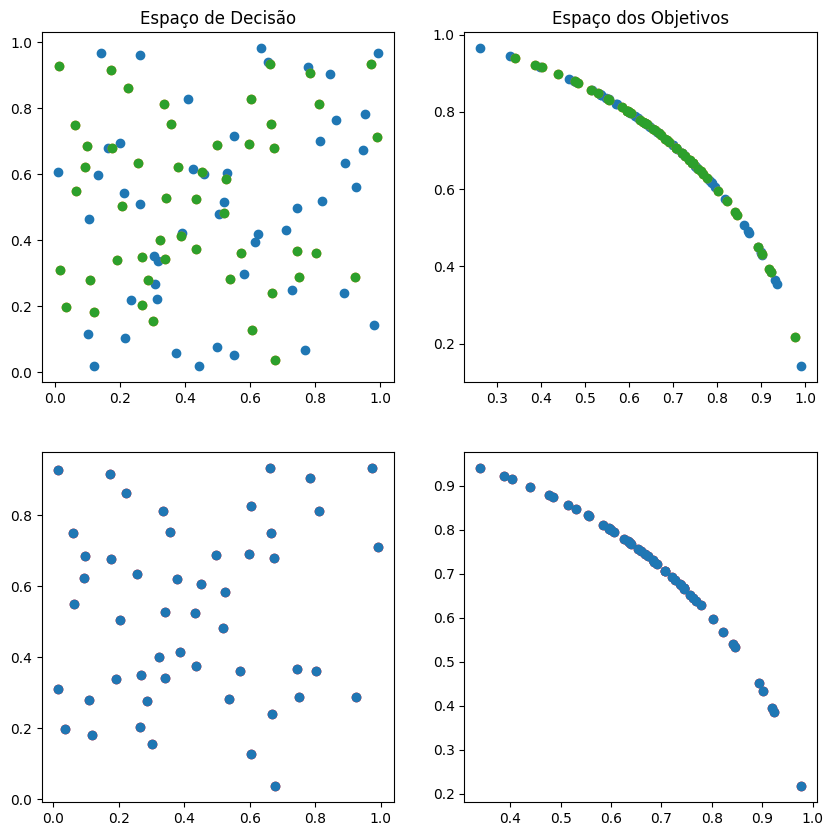

In [173]:
GraficaGenetico(PopInit, PopFinal, PopFinalnomDom, funcaoObj2)

In [130]:
hv, uni = calculaHV_Uni(PopFinalnomDom, ref1, funcaoObj)
print(hv, uni)

49.85894817842568 0.05575227701557634


#Testes

In [146]:
def TesteGen(popSizes, func, it, qtTest, ref, r, n = 2, progress = 10, dx = DominaX, profundidade = False):

  finalResults = []
  for pop in popSizes:
    results = []
    print(f'Pop: {pop}')
    for c in range(qtTest):
      if (c%progress == 0):
        print(f'{c}/{qtTest}')
      PopInit, PopFinal, PopFinalnomDom = Genetico(pop, it, progress=None, funcaoObj=func, n=n, r=r, dx = dx, profundidade = profundidade)
      hv, uni = calculaHV_Uni(PopFinalnomDom, ref, func)
      results.append([hv, uni])
      print([hv, uni])

    results = np.array(results)
    hvmean = results[:,0].mean()
    unimean = results[:,1].mean()
    results = np.array(results)
    print(f'População de tamanho {pop} -- HV = {hvmean} Uniformidade = {unimean}')
    finalResults.append([hvmean, unimean])

  return np.array(finalResults)


In [151]:
def grafica(res1, res2, res3):
  resultados = [res1[0], res2[0], res3[0]]
  print(res1[0])
  categories = ['pop 30', 'pop 40', 'pop 50']
  labels = ['d(x) do SPEA-2', 'Dominância', 'Profundidade']
  values = [res1[:, 0], res2[:, 0], res3[:, 0]]
  values2 = [res1[:, 1], res2[:, 1], res3[:, 1]]


  x = np.arange(len(categories))  # the label locations
  width = 0.2  # the width of the bars

  # Plotting
  fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.8})
  for i, label in enumerate(labels):
    x = np.arange(len(categories)) + i * width - 1  # shift each group's bars slightly
    ax[0].bar(x, values[i], width, label=label)
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax[0].set_ylabel('HiperVolume')
  ax[0].set_title('Medida de HiperVolume')
  ax[0].set_xticks(x)
  ax[0].set_xticklabels(categories)
  ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))



  for i, label in enumerate(labels):
    x = np.arange(len(categories)) + i * width - 1  # shift each group's bars slightly
    ax[1].bar(x, values2[i], width, label=label)
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax[1].set_ylabel('Uniformidade')
  ax[1].set_title('Medida de Uniformidade')
  ax[1].set_xticks(x)
  ax[1].set_xticklabels(categories)
  ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))


In [148]:
np.random.seed(seed=928393774)
res3 = TesteGen([30,40,50], funcaoObj, 500, 15, [8,8],(-5,5), progress=5, dx=DominaXProf, profundidade = True)
res2 = TesteGen([30,40,50], funcaoObj, 500, 15, [8,8],(-5,5), progress=5, dx=DominaXSum)
res1 = TesteGen([30,40,50], funcaoObj, 500, 15, [8,8],(-5,5), progress=5)


Pop: 30
0/15
[50.28321155040644, 0.11403160771152286]
[48.36276073599073, 0.06584087084641788]
[49.95308596713366, 0.07316763221028356]
[49.30482379610387, 0.09440868455004188]
[42.13810623044971, 0.06708724782538013]
5/15
[50.79139941056575, 0.04029664196951884]
[48.402568309832944, 0.0461171300019957]
[50.80406295545524, 0.09461024980267341]
[41.696037701126464, 0.08711612377805304]
[50.82456730424339, 0.09980153704829536]
10/15
[49.276000784722385, 0.054551906246577894]
[42.080227139073386, 0.07246356327027949]
[49.38479481746065, 0.09040025853016291]
[51.010090818033746, 0.11469105014770647]
[44.754841505114875, 0.077216723254801]
População de tamanho 30 -- HV = 47.93777193504754 Uniformidade = 0.07945341514624736
Pop: 40
0/15
[51.75347963088517, 0.056401020307646904]
[46.759229922658264, 0.02971675243935401]
[50.5084294223227, 0.05620347341194343]
[41.08257182832989, 0.06314064136725553]
[40.039792538261764, 0.06127553018031229]
5/15
[51.263092901843805, 0.08490472508782848]
[46.8

[[50.88993722  0.04654713]
 [51.70984317  0.03397761]
 [51.92561589  0.02818864]]
[50.88993722  0.04654713]


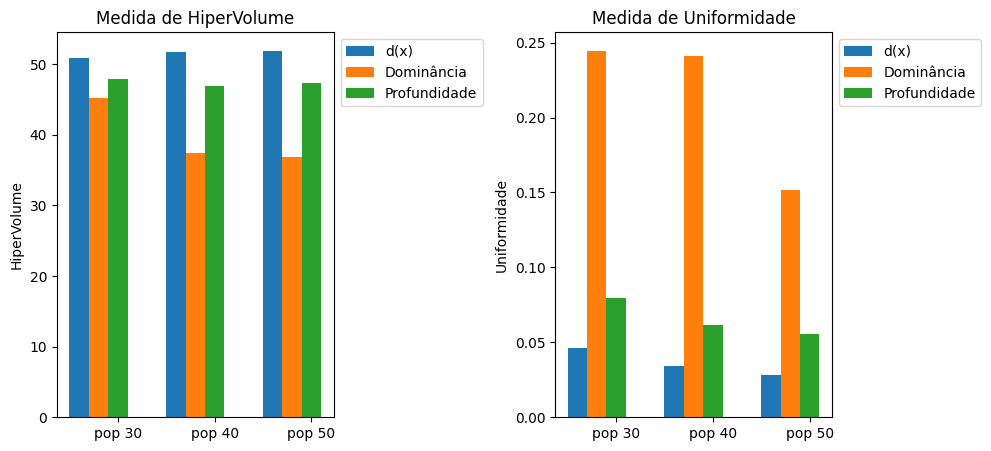

In [149]:
print(res1)
grafica(res1,res2,res3)

In [152]:
np.random.seed(seed=928393774)
res3 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1), progress=5, dx=DominaXProf, profundidade = True)
res2 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1), progress=5, dx=DominaXSum)
res1 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1), progress=5)

Pop: 30
0/15
[0.1822462743664825, 0.06363892299663206]
[0.19454272221192143, 0.07175965719897687]
[0.18766463466064, 0.10326889158589288]
[0.18894360046668562, 0.08419605687543896]
[0.16265827444952433, 0.06366450739517376]
5/15
[0.17985556370596464, 0.06075577650661919]
[0.1922809969506387, 0.06294780269280292]
[0.1686620026040206, 0.07366194634796576]
[0.19189896371724094, 0.0914442335248058]
[0.18936450890767614, 0.07893607950336225]
10/15
[0.17935820681748627, 0.08531139868759885]
[0.19067759002837414, 0.08918723649094502]
[0.18243475373655949, 0.08033040329753004]
[0.1879175357993008, 0.07567453844228891]
[0.18815974826493875, 0.07628042518571232]
População de tamanho 30 -- HV = 0.1844443584458303 Uniformidade = 0.07740385844878304
Pop: 40
0/15
[0.19538537708570988, 0.05336019437316125]
[0.19066457563946293, 0.0408535831623009]
[0.19207713873491503, 0.06970958825850078]
[0.19665079183422962, 0.07150313313740814]
[0.19102993234299584, 0.0675054890329572]
5/15
[0.19363984216570856, 

[[0.19044658 0.08076847]
 [0.1900925  0.06817043]
 [0.19651697 0.06431933]]
[0.19044658 0.08076847]


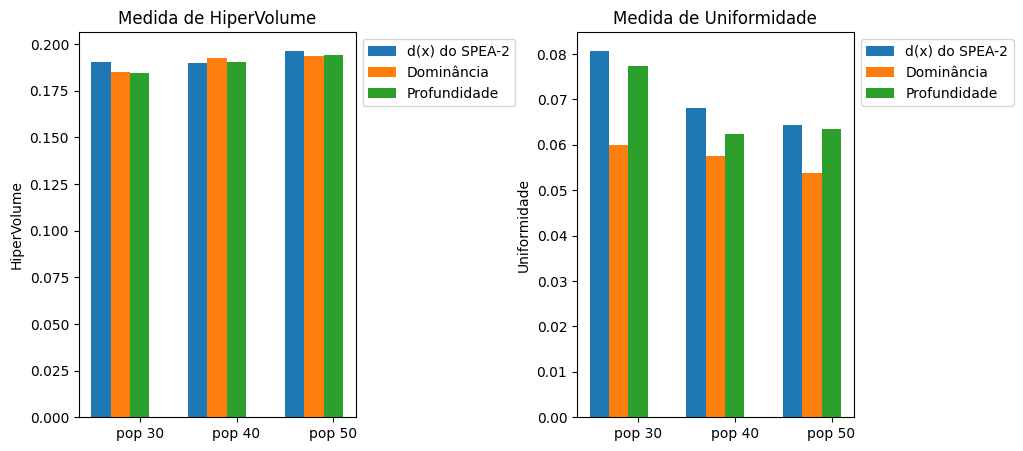

In [153]:
print(res1)
grafica(res1,res2,res3)

In [154]:
np.random.seed(seed=928393774)
res3 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1), n=3,  progress=5, dx=DominaXProf, profundidade = True)
res2 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1), n=3,  progress=5, dx=DominaXSum)
res1 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1),n=3, progress=5)

Pop: 30
0/15
[0.16459047632894322, 0.1372933264465872]
[0.16800319053464036, 0.15014043676073321]
[0.18370993291713777, 0.17544145167144634]
[0.17736243598576829, 0.15214913964413132]
[0.1658156417854922, 0.14704612085628316]
5/15
[0.1749353562725982, 0.15695328378108006]
[0.1828904544339488, 0.19716119239862126]
[0.18798272115118014, 0.1903526536962822]
[0.16544383595714163, 0.1482247350334402]
[0.16063103106755494, 0.1408847334527605]
10/15
[0.17600423857867117, 0.18196587338240264]
[0.16970006726142428, 0.14589692856128256]
[0.17822928630528653, 0.17585389694125667]
[0.18011511581975248, 0.1528361057260294]
[0.18364678637060913, 0.14604040060056742]
População de tamanho 30 -- HV = 0.17460403805134325 Uniformidade = 0.15988268526352695
Pop: 40
0/15
[0.19170949753712185, 0.1206830042985164]
[0.1837542198043712, 0.18608382594412604]
[0.18189154799424134, 0.14110952732182322]
[0.18045102704243676, 0.1706496368620687]
[0.18469053453144252, 0.1751746317283434]
5/15
[0.1816129056755166, 0.

[0.17774818 0.16250932]


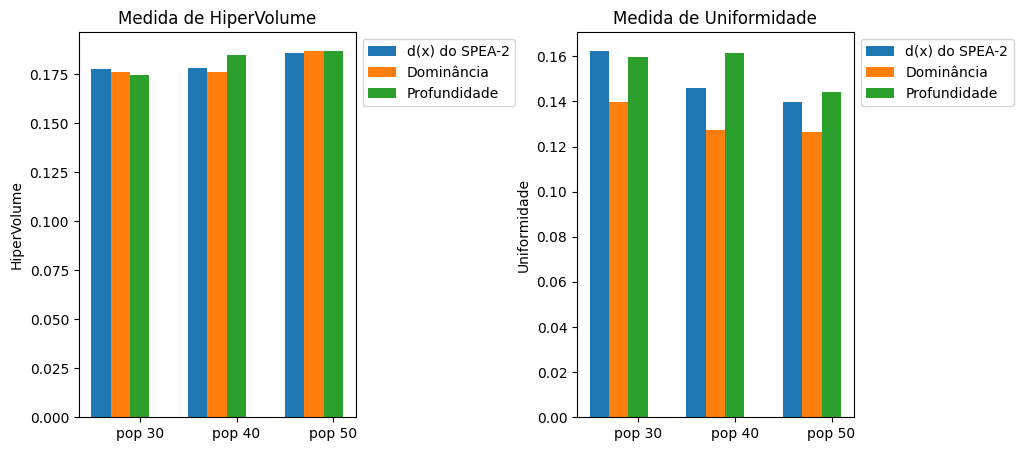

In [155]:
grafica(res1,res2,res3)

In [156]:
np.random.seed(seed=928393774)
res3 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1), n=10,  progress=5, dx=DominaXProf, profundidade = True)
res2 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1), n=10,  progress=5, dx=DominaXSum)
res1 = TesteGen([30,40,50], funcaoObj2, 500, 15, [1,1],(0,1),n=10, progress=5)

Pop: 30
0/15
[0.14464611732646, 0.7076514719866345]
[0.13301357312972684, 0.686094510348683]
[0.1519133061954349, 0.701148961182282]
[0.15263631273374303, 0.7840100719333801]
[0.1531735298132203, 0.6022727228326539]
5/15
[0.1562402071202198, 0.7664012435198279]
[0.13850486006037888, 0.6836512218037256]
[0.1593325386093477, 0.6597074712467518]
[0.1487076293113625, 0.5217167387276723]
[0.15308669171541683, 0.6319053141808091]
10/15
[0.14635343838751702, 0.6851116918794549]
[0.13661089908684207, 0.6322591097591318]
[0.15082063164308648, 0.6953443745798327]
[0.1505379400579064, 0.5935054525886991]
[0.14417275135024898, 0.6200362337052538]
População de tamanho 30 -- HV = 0.14798336176939408 Uniformidade = 0.6647211060183195
Pop: 40
0/15
[0.16025549367355515, 0.6281331950559291]
[0.16386981139648316, 0.7649535053000345]
[0.15459339729426363, 0.7270130087534439]
[0.14540256516075695, 0.6382092954127209]
[0.1424639573967072, 0.7051372438606193]
5/15
[0.1566888548973766, 0.6302822864493616]
[0.

[0.14687677 0.64435819]


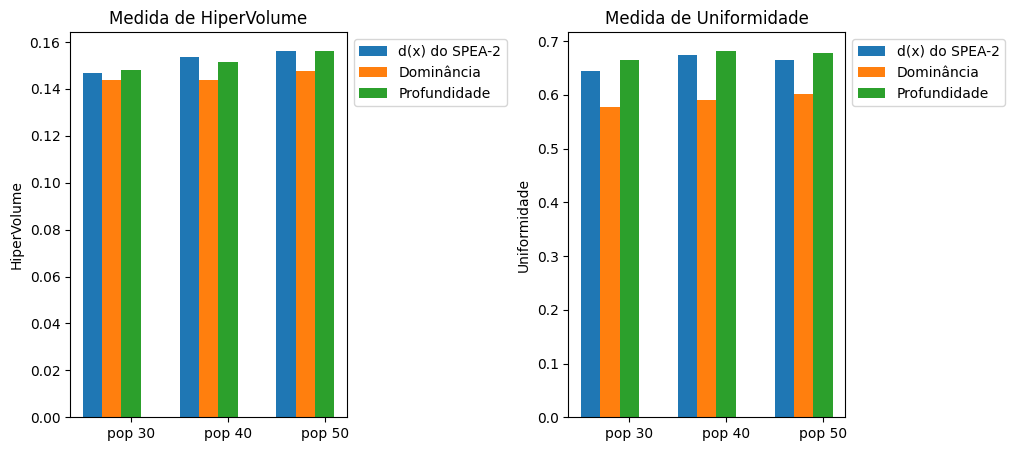

In [157]:
grafica(res1,res2,res3)